In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from datetime import datetime

# === Load and prepare data ===
df = pd.read_csv("/Users/gabriel/Desktop/marcy/Mod-5-Project/Data/LinkNYC_weekly_KPIs_defined.csv")


In [3]:
df["week_end"] = pd.to_datetime(df["Report Ending (weekly starting on Sundays)"], errors="coerce")
df = df.sort_values("week_end").reset_index(drop=True)

def to_minutes(t):
    try:
        h, m, s = map(int, t.split(":"))
        return h * 60 + m + s / 60
    except:
        return np.nan
df["Avg_Session_Minutes"] = df["Average Session Length"].apply(to_minutes)

df['date'] = df["week_end"] # Replace with your actual column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['dayofweek'] = df['date'].dt.dayofweek  # 0=Monday
df['quarter'] = df['date'].dt.quarter



monthly = df.groupby(['year', 'month']).agg({
    'Number of Unique Clients': 'sum',
    'Number of Sessions': 'sum',
    'Avg_Session_Minutes': 'mean',
    'TB Downloaded': 'sum',
    'TB Uploaded': 'sum'
}).reset_index()
# Total data transferred
monthly['Total_TB_Transferred'] = monthly['TB Downloaded'] + monthly['TB Uploaded']
# Step conversion rates
monthly['sessions_per_client'] = monthly['Number of Sessions'] / monthly['Number of Unique Clients']
monthly['tb_per_session'] = monthly['Total_TB_Transferred'] / monthly['Number of Sessions']
monthly['tb_per_client'] = monthly['Total_TB_Transferred'] / monthly['Number of Unique Clients']
# relative drop-offs as percentages
monthly['step_1_conversion_rate'] = 1.0  # baseline (100%)
monthly['step_2_conversion_rate'] = monthly['Number of Sessions'] / monthly['Number of Unique Clients']
monthly['step_3_conversion_rate'] = monthly['Total_TB_Transferred'] * 1024 / monthly['Number of Sessions'] 
monthly['overall_conversion_rate'] = monthly['Total_TB_Transferred'] * 1024/ monthly['Number of Unique Clients']
monthly['step_2_conversion_rate'] = (monthly['step_2_conversion_rate'] * 100).map('{:,.2f}%'.format)
monthly['step_3_conversion_rate'] = (monthly['step_3_conversion_rate'] * 100).map('{:,.2f}%'.format)
monthly['overall_conversion_rate'] = (monthly['overall_conversion_rate'] * 100).map('{:,.2f}%'.format)
funnel_columns = [
    'year',
    'month',
    'Number of Unique Clients',
    'Number of Sessions',
    'Total_TB_Transferred',
    'step_2_conversion_rate',
    'step_3_conversion_rate',
    'overall_conversion_rate'
]
print(monthly[funnel_columns].to_string(index=False))

 year  month  Number of Unique Clients  Number of Sessions  Total_TB_Transferred step_2_conversion_rate step_3_conversion_rate overall_conversion_rate
 2020      1                   2518768            88919633                514.54              3,530.28%                  0.59%                  20.92%
 2020      2                   2444926            87385233                528.94              3,574.15%                  0.62%                  22.15%
 2020      3                   2388305            77992703                560.55              3,265.61%                  0.74%                  24.03%
 2020      4                    982666            18003470                393.74              1,832.10%                  2.24%                  41.03%
 2020      5                   1320496            25797422                461.77              1,953.62%                  1.83%                  35.81%
 2020      6                   1230493            27445933                374.49              

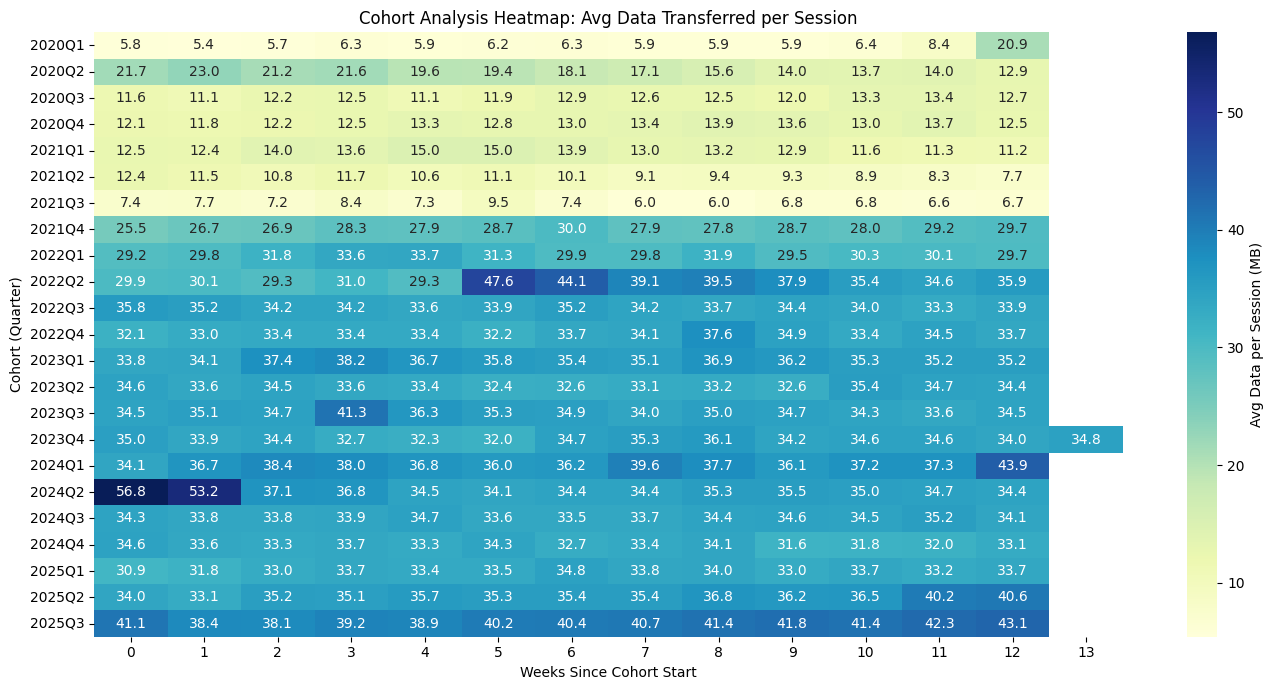

In [4]:
# Avg Data Transferred per Session (in TB)
df['Avg_Data_Transferred_TB'] = (df['TB Downloaded'] + df['TB Uploaded']) / df['Number of Sessions']
# Add quarter-based cohort assignment
df['cohort'] = df['week_end'].dt.to_period('Q')
# Weeks since cohort start 
df['cohort_week'] = df.groupby('cohort')['week_end'].rank(method='dense').astype(int) - 1
# Create pivot table for heatmap
cohort_pivot = df.pivot_table(
    index='cohort_week',
    columns='cohort',
    values='Avg_Data_Transferred_TB'
)
plt.figure(figsize=(14, 7))
# Adjusts TB to GB 
sns.heatmap(cohort_pivot.T * 1e6, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Avg Data per Session (MB)'})
plt.title("Cohort Analysis Heatmap: Avg Data Transferred per Session")
plt.ylabel("Cohort (Quarter)")
plt.xlabel("Weeks Since Cohort Start")
plt.tight_layout()
plt.show()

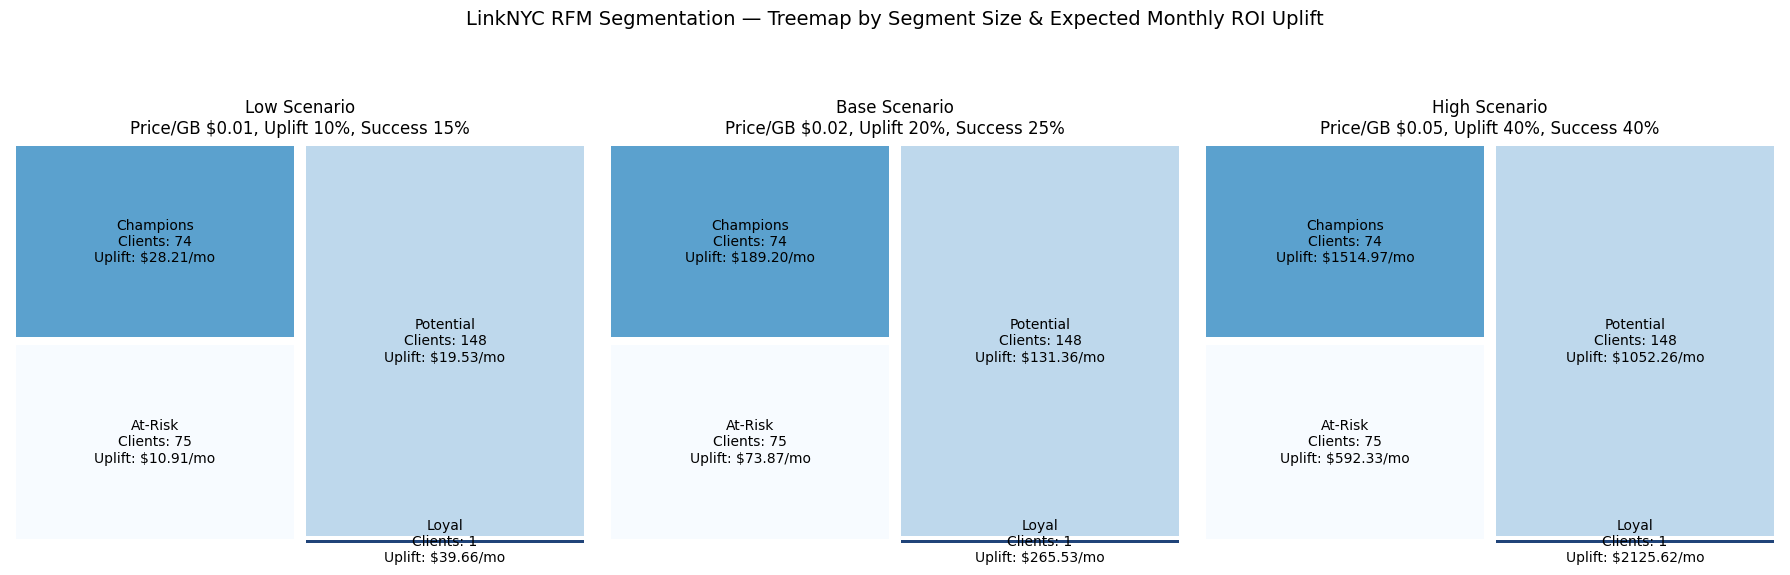

In [6]:
# --- RFM Segmentation + ROI Treemap for LinkNYC ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify
from datetime import datetime

# === Load and prepare data ===
df = pd.read_csv("/Users/gabriel/Desktop/marcy/Mod-5-Project/Data/LinkNYC_weekly_KPIs_defined.csv")

# Convert date/week column
week_col = [c for c in df.columns if 'week' in c.lower() or 'report ending' in c.lower()][0]
df[week_col] = pd.to_datetime(df[week_col])

# Compute total_gb (TB → GB)
tb_down_col = [c for c in df.columns if 'download' in c.lower() and 'tb' in c.lower()][0]
tb_up_col = [c for c in df.columns if 'upload' in c.lower() and 'tb' in c.lower()][0]
df['total_gb'] = (df[tb_down_col].fillna(0) + df[tb_up_col].fillna(0)) * 1024

# Create heavy_usage_week indicator
threshold = df['total_gb'].quantile(0.75)
df['heavy_usage_week'] = (df['total_gb'] > threshold).astype(int)

# Identify ID column
id_col = [c for c in df.columns if 'unique clients' in c.lower()][0]
df[id_col] = df[id_col].astype(str)

# === Aggregate RFM metrics ===
max_week = df[week_col].max()
min_week = df[week_col].min()
total_weeks = int(((max_week - min_week).days) // 7)

rfm_rows = []
for name, group in df.groupby(id_col):
    heavy_weeks = group.loc[group['heavy_usage_week'] == 1, week_col]
    recency = (max_week - heavy_weeks.max()).days // 7 if not heavy_weeks.empty else total_weeks + 1
    frequency = group['heavy_usage_week'].sum()
    monetary = group['total_gb'].sum()
    rfm_rows.append({
        'client': name,
        'Recency': recency,
        'Frequency': frequency,
        'Monetary': monetary
    })

rfm = pd.DataFrame(rfm_rows)

# === Compute quartile scores ===
r_quartiles = rfm['Recency'].quantile([0.25, 0.5, 0.75]).to_dict()
f_quartiles = rfm['Frequency'].quantile([0.25, 0.5, 0.75]).to_dict()
m_quartiles = rfm['Monetary'].quantile([0.25, 0.5, 0.75]).to_dict()

def r_score(x):
    if x <= r_quartiles[0.25]: return 4
    elif x <= r_quartiles[0.5]: return 3
    elif x <= r_quartiles[0.75]: return 2
    else: return 1

def f_score(x):
    if x <= f_quartiles[0.25]: return 1
    elif x <= f_quartiles[0.5]: return 2
    elif x <= f_quartiles[0.75]: return 3
    else: return 4

def m_score(x):
    if x <= m_quartiles[0.25]: return 1
    elif x <= m_quartiles[0.5]: return 2
    elif x <= m_quartiles[0.75]: return 3
    else: return 4

rfm['R'] = rfm['Recency'].apply(r_score)
rfm['F'] = rfm['Frequency'].apply(f_score)
rfm['M'] = rfm['Monetary'].apply(m_score)
rfm['RFM_Total'] = rfm[['R','F','M']].sum(axis=1)

def segment_label(score):
    if score >= 11: return 'Champions'
    elif score >= 9: return 'Loyal'
    elif score >= 7: return 'Potential'
    elif score >= 5: return 'At-Risk'
    elif score >= 3: return 'Hibernating'
    else: return 'Lost'

rfm['Segment'] = rfm['RFM_Total'].apply(segment_label)

# === Summarize by Segment ===
segment_summary = (
    rfm.groupby('Segment')
    .agg(
        num_clients=('client','count'),
        avg_recency=('Recency','mean'),
        avg_frequency=('Frequency','mean'),
        avg_monetary=('Monetary','mean')
    )
    .reset_index()
)

# === ROI Scenarios ===
scenarios = {
    'Low': {'price_per_gb': 0.01, 'uplift_pct': 0.10, 'success_rate': 0.15, 'campaign_cost': 2.0},
    'Base': {'price_per_gb': 0.02, 'uplift_pct': 0.20, 'success_rate': 0.25, 'campaign_cost': 2.0},
    'High': {'price_per_gb': 0.05, 'uplift_pct': 0.40, 'success_rate': 0.40, 'campaign_cost': 2.0},
}

for name, params in scenarios.items():
    price, uplift, success, cost = params.values()
    expected = segment_summary['avg_monetary'] * uplift * price * success
    segment_summary[f'{name}_exp_monthly_revenue_uplift_per_client'] = expected - (cost * 0.1)

# === Plot RFM Treemap ===
plt.figure(figsize=(18,6))
for i, scenario in enumerate(scenarios.keys(), 1):
    plt.subplot(1, 3, i)
    sizes = segment_summary['num_clients']
    values = segment_summary[f'{scenario}_exp_monthly_revenue_uplift_per_client']
    labels = segment_summary['Segment']
    
    cmap = plt.cm.Blues
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())
    colors = [cmap(norm(v)) for v in values]
    
    formatted_labels = [
        f"{lab}\nClients: {int(n)}\nUplift: ${v:.2f}/mo"
        for lab, n, v in zip(labels, sizes, values)
    ]
    
    squarify.plot(sizes=sizes, label=formatted_labels, color=colors, pad=True, alpha=0.9)
    plt.axis('off')
    p = scenarios[scenario]
    plt.title(f"{scenario} Scenario\nPrice/GB ${p['price_per_gb']}, Uplift {int(p['uplift_pct']*100)}%, Success {int(p['success_rate']*100)}%")

plt.suptitle(
    "LinkNYC RFM Segmentation — Treemap by Segment Size & Expected Monthly ROI Uplift\n"
   ,
    fontsize=14
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [7]:
rfm['Segment'].value_counts()

Segment
Potential    148
At-Risk       75
Champions     74
Loyal          1
Name: count, dtype: int64

Interpreting the RFM Treemap and ROI Scenarios

The treemap above visualizes the LinkNYC user segments based on Recency (R), Frequency (F), and Monetary usage (M) behaviors.
Each rectangle represents a group of clients who share similar engagement and data usage patterns.

| Segment         | Description                                                                            |
| --------------- | -------------------------------------------------------------------------------------- |
| **Champions**   | Very recent and frequent users with high data usage — most profitable and loyal group. |
| **Loyal**       | Regular users with steady engagement, valuable for retention and upsell campaigns.     |
| **Potential**   | Moderate usage and recency — promising for reactivation marketing.                     |
| **At-Risk**     | Declining or less frequent users who could be recovered with targeted offers.          |
| **Hibernating** | Rarely active users — low immediate ROI potential.                                     |
| **Lost**        | Inactive for long periods — minimal ROI unless re-engagement cost is very low.         |

Half of these descriptions are not shown in the treemap as there aren't many entries that fit those descriptions.

Stakeholders can visualize where engagement dollars yield the highest return.

Focusing on Champions, Loyal, and At-Risk users offers the best cost-to-revenue ratio balancing retention and growth.